In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,BatchNormalization,Flatten,Input,AveragePooling2D, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from PIL import Image, ImageOps
import seaborn as sns
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import optimizers
import tensorflow as tensorflow
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras import layers
from keras import optimizers
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import SeparableConv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers import SpatialDropout2D
from keras.layers.core import Lambda
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.regularizers import l2

In [ ]:
# cloud based platform - storage, mount the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!rm -rf  /content/drive/MyDrive/Emotion_Detection/utkface_aligned_cropped
#!unzip -q  /content/drive/MyDrive/Emotion_Detection/archive.zip -d  /content/drive/MyDrive/Emotion_Detection/

# New Section

In [ ]:
path = '/content/drive/MyDrive/Emotion_Detection/UTKFace/'
#/content/drive/MyDrive/Emotion_Detection/crop_part1
os.chdir(path)
file_list = os.listdir() #Go path and list files
print("Number Of İmages: ", len(file_list))
#Gender
gender = []
for i in file_list:
    gender.append(i.split('_')[1])

gender_labels= ["Male","Female"]

gender_classes = []
y_gender= []
for i in gender:
    i= int(i)
    if i== 0:
        gender_classes.append(0)
    else:
        gender_classes.append(1)
    y_gender.append(i)

gender_classes= np.array(gender_classes)
print("gender_classes shape: ",gender_classes.shape)


Number Of İmages:  23708
gender_classes shape:  (23708,)


In [ ]:
images = []
age = []
genders = []

In [ ]:
from keras_preprocessing.image.affine_transformations import apply_brightness_shift
from keras_preprocessing.image.affine_transformations import apply_brightness_shift

#for i in os.listdir(path)[0:9000]:
for i in os.listdir(path):
    split = i.split('_')
    if (int(split[0])) <=20:
        age.append(0)
    elif (int(split[0])) > 20 and (int(split[0])) <=40:
        age.append(1)
    elif (int(split[0])) > 40 and (int(split[0])) <=60:
        age.append(2)
    elif (int(split[0])) > 60 and (int(split[0])) <=80:
        age.append(3)
    elif (int(split[0])) > 80: 
        age.append(4)
        print(age)
 



IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
age = np.array(age)

In [ ]:
age.shape

(23708,)

In [ ]:
np.unique(age)

array([0, 1, 2, 3, 4])

In [ ]:
age[11]

4

In [ ]:
## age_continuous
age_cont = []
for i in file_list:
    age_cont.append(int(i.split("_")[0]))
    
age_cont = np.array(age_cont)
print(age_cont.shape)

(23708,)


In [ ]:
os.chdir(path)
file_list = os.listdir()
path

'/content/drive/MyDrive/Emotion_Detection/UTKFace/'

In [ ]:
x_data=[]
for file in file_list:
    img= cv2.imread(file)
    img=cv2.resize(img,dsize = (48,48)) # (200,200)--->(48,48)
    x_data.append(img)
x_data= np.array(x_data)
print("x_data shape: ",x_data.shape)

x_data shape:  (23708, 48, 48, 3)


In [ ]:
# parameters
input_shape = (48, 48, 3)
batch_size=32
verbose = 1
num_epochs = 100
patience = 16
base_path = '/content/drive/My Drive/Emotion_Detection/GENDER_AGE/'
l2_regularization=0.001

In [ ]:
## Train-Test Split for age
x_train,x_test,y_train,y_test=train_test_split(x_data,age,test_size=0.2,
                                               shuffle=True,random_state=42)

#one hot encoding
y_train= to_categorical(y_train,num_classes=5)
y_test= to_categorical(y_test,num_classes=5) 
x_train = x_train / 255.
x_test = x_test / 255.

print("Samples in Training:",x_train.shape)
print("Samples in Testing:",x_test.shape)


print("y_train shape: ",y_train.shape)
print("y_test shape: ",y_test.shape)

input_shape= x_train.shape[1:] #we don't take the number of samples
print("input shape: ",input_shape)

Samples in Training: (18966, 48, 48, 3)
Samples in Testing: (4742, 48, 48, 3)
y_train shape:  (18966, 5)
y_test shape:  (4742, 5)
input shape:  (48, 48, 3)


In [ ]:
def entry_flow(inputs) :

    x = Conv2D(32, 5, strides = 2, padding='same')(inputs)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(64,5,padding='same')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    previous_block_activation = x

    for size in [32, 64, 256] :

        x = SeparableConv2D(size, 5, padding='same')(x)
        x = Activation('relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)

        x = SeparableConv2D(size, 5, padding='same')(x)
        x = Activation('relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)
  
        x = MaxPooling2D(3, strides=2, padding='same')(x)

        residual = Conv2D(size, 1, strides=2, padding='same')(previous_block_activation)

        x = tensorflow.keras.layers.Add()([x, residual])
        previous_block_activation = x

    return x

In [ ]:
def middle_flow(x, num_blocks=14) :

    previous_block_activation = x

    for _ in range(num_blocks) :

        x = Activation('relu')(x)
        x = SeparableConv2D(256, 5, padding='same')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(256, 5, padding='same')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(256, 5, padding='same')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)
        
        x = Activation('relu')(x)
        x = SeparableConv2D(256, 5, padding='same')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)
        
        x = Activation('relu')(x)
        x = SeparableConv2D(256, 5, padding='same')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)

        x = tensorflow.keras.layers.Add()([x, previous_block_activation])
        previous_block_activation = x

    return x

In [ ]:
def exit_flow(x) :

    previous_block_activation = x

    x = Activation('relu')(x)
    x = SeparableConv2D(312, 5, padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Activation('relu')(x)
    x = SeparableConv2D(624, 5, padding='same')(x) 
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = MaxPooling2D(3, strides=2, padding='same')(x)

    residual = Conv2D(624, 1, strides=2, padding='same')(previous_block_activation)
    x = tensorflow.keras.layers.Add()([x, residual])


    x = SeparableConv2D(312, 5, padding='same')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = SeparableConv2D(312, 3, padding='same')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(5, activation='softmax')(x)

    return x


In [ ]:
img_input = Input(shape=(48, 48, 3))
output = exit_flow(middle_flow(entry_flow(img_input)))

In [ ]:
age_model = Model(img_input, output)

In [ ]:
datagen = ImageDataGenerator(
      width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)     
test_datagen = ImageDataGenerator()

train1 = datagen.flow(x_train, y_train, batch_size=batch_size)
test1 = test_datagen.flow(x_test, y_test, batch_size=batch_size)

In [ ]:
# run model for gender
age_model.compile(loss='mean_squared_error', optimizer= tensorflow.optimizers.Adam(lr=0.001), metrics=["accuracy"])

# callbacks
log_file_path = base_path + 'age_training.log'
csv_logger = CSVLogger(log_file_path, append=False)
early_stop = EarlyStopping('val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1, patience=int(patience/4), verbose=1)
trained_models_path = base_path + 'age_model_Xception'
model_names = trained_models_path + '.{epoch:02d}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,save_best_only=True)
callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]

age = age_model.fit(train1, verbose=1, callbacks=callbacks, validation_data=test1,  epochs=90,
                batch_size=batch_size )

Epoch 1/90


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


592/593 [============================>.] - ETA: 0s - loss: 0.1198 - accuracy: 0.5482
Epoch 1: val_loss improved from inf to 0.11384, saving model to /content/drive/My Drive/Emotion_Detection/GENDER_AGE/age_model_Xception.01.hdf5
593/593 [==============================] - 63s 73ms/step - loss: 0.1198 - accuracy: 0.5484 - val_loss: 0.1138 - val_accuracy: 0.5784 - lr: 0.0010
Epoch 2/90
592/593 [============================>.] - ETA: 0s - loss: 0.1059 - accuracy: 0.6078
Epoch 2: val_loss did not improve from 0.11384
593/593 [==============================] - 39s 66ms/step - loss: 0.1059 - accuracy: 0.6079 - val_loss: 0.1348 - val_accuracy: 0.5148 - lr: 0.0010
Epoch 3/90
592/593 [============================>.] - ETA: 0s - loss: 0.1004 - accuracy: 0.6305
Epoch 3: val_loss improved from 0.11384 to 0.09843, saving model to /content/drive/My Drive/Emotion_Detection/GENDER_AGE/age_model_Xception.03.hdf5
593/593 [==============================] - 41s 68ms/step - loss: 0.1004 - accuracy: 0.6306 -

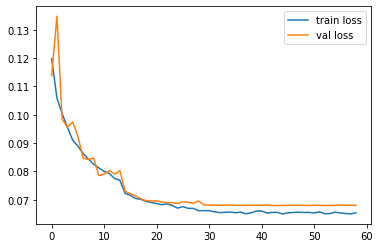

<Figure size 432x288 with 0 Axes>

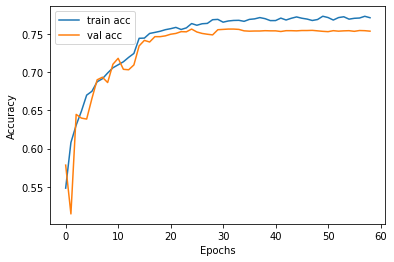

<Figure size 432x288 with 0 Axes>

In [ ]:
#Train and Validation Loss
plt.plot(age.history["loss"],label="train loss")
plt.plot(age.history["val_loss"],label="val loss")
plt.legend()
fig1 = plt.gcf() # I create figure because ı want to save
plt.show()
plt.draw()
#fig1.savefig('ageclfloss.png')

plt.figure()

##Train and Validation Accuracy
plt.plot(age.history["accuracy"],label="train acc")
plt.plot(age.history["val_accuracy"],label="val acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

fig2 = plt.gcf()
plt.show()
plt.draw()
#fig2.savefig('ageclfacc.png')

In [ ]:
## Train-Test Split for gender
x_train,x_test,y_train,y_test=train_test_split(x_data,gender_classes,test_size=0.2,
                                               shuffle=True,random_state=42)

#one hot encoding
y_train= to_categorical(y_train,num_classes=2)
y_test= to_categorical(y_test,num_classes=2) 
x_train = x_train / 255.
x_test = x_test / 255.

print("Samples in Training:",x_train.shape)
print("Samples in Testing:",x_test.shape)


print("y_train shape: ",y_train.shape)
print("y_test shape: ",y_test.shape)

input_shape= x_train.shape[1:] #we don't take the number of samples
print("input shape: ",input_shape)

Samples in Training: (18966, 48, 48, 3)
Samples in Testing: (4742, 48, 48, 3)
y_train shape:  (18966, 2)
y_test shape:  (4742, 2)
input shape:  (48, 48, 3)


In [ ]:
def exit_gender_flow(x) :

    previous_block_activation = x

    x = Activation('relu')(x)
    x = SeparableConv2D(312, 5, padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Activation('relu')(x)
    x = SeparableConv2D(624, 5, padding='same')(x) 
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = MaxPooling2D(3, strides=2, padding='same')(x)

    residual = Conv2D(624, 1, strides=2, padding='same')(previous_block_activation)
    x = tensorflow.keras.layers.Add()([x, residual])


    x = SeparableConv2D(624, 5, padding='same')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = SeparableConv2D(312, 3, padding='same')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation='sigmoid')(x)

    return x


In [ ]:
img_input = Input(shape=(48, 48, 3))
output = exit_gender_flow(middle_flow(entry_flow(img_input)))

In [ ]:
gender_model = Model(img_input, output)

In [ ]:
datagen = ImageDataGenerator(
      width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)     
test_datagen = ImageDataGenerator()

train2 = datagen.flow(x_train, y_train, batch_size=batch_size)
test2 = test_datagen.flow(x_test, y_test, batch_size=batch_size)
gender_model.compile()

In [ ]:
# run model for gender
gender_model.compile(loss="binary_crossentropy", optimizer= tensorflow.optimizers.Adam(lr=0.001), metrics=["accuracy"])

# callbacks
log_file_path = base_path + 'gender_training.log'
csv_logger = CSVLogger(log_file_path, append=False)
early_stop = EarlyStopping('val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1, patience=int(patience/4), verbose=1)
trained_models_path = base_path + 'gender_model_Xception'
model_names = trained_models_path + '.{epoch:02d}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,save_best_only=True)
callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]

gender = gender_model.fit(train2, verbose=1, callbacks=callbacks, validation_data=test2,  epochs=num_epochs,
                batch_size=batch_size )

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


592/593 [============================>.] - ETA: 0s - loss: 0.5072 - accuracy: 0.7480
Epoch 1: val_loss improved from inf to 0.58226, saving model to /content/drive/My Drive/Emotion_Detection/GENDER_AGE/gender_model_Xception.01.hdf5
593/593 [==============================] - 55s 72ms/step - loss: 0.5070 - accuracy: 0.7481 - val_loss: 0.5823 - val_accuracy: 0.6742 - lr: 0.0010
Epoch 2/100
593/593 [==============================] - ETA: 0s - loss: 0.3781 - accuracy: 0.8304
Epoch 2: val_loss improved from 0.58226 to 0.34506, saving model to /content/drive/My Drive/Emotion_Detection/GENDER_AGE/gender_model_Xception.02.hdf5
593/593 [==============================] - 41s 70ms/step - loss: 0.3781 - accuracy: 0.8304 - val_loss: 0.3451 - val_accuracy: 0.8435 - lr: 0.0010
Epoch 3/100
593/593 [==============================] - ETA: 0s - loss: 0.3499 - accuracy: 0.8445
Epoch 3: val_loss did not improve from 0.34506
593/593 [==============================] - 40s 67ms/step - loss: 0.3499 - accuracy: 

In [ ]:
#Train and Validation Loss
plt.plot(gender.history["loss"],label="train loss")
plt.plot(gender.history["val_loss"],label="val loss")
plt.legend()
fig1 = plt.gcf() # I create figure because ı want to save
plt.show()
plt.draw()
#fig1.savefig('genderclfloss.png')

plt.figure()

##Train and Validation Accuracy
plt.plot(gender.history["accuracy"],label="train acc")
plt.plot(gender.history["val_accuracy"],label="val acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

fig2 = plt.gcf()
plt.show()
plt.draw()
#fig2.savefig('genderclfacc.png')

In [ ]:
## gender results
results= gender_model.evaluate(x_test,y_test)
print("Results: ",results)

In [ ]:
#age= to_categorical(age,num_classes=7)